In [1]:
import json
import re
import pandas as pd 
import numpy as np
# from nltk.stem.porter import PorterStemmer
import string
from nltk import word_tokenize, pos_tag
import spacy
# from collections import Counter
import os
import pickle
from pathlib import Path

In [2]:
from sentence_transformers import SentenceTransformer, CrossEncoder
from ranker import TransformerRanker, CrossEncoderRanker, Classifier
from preprocessor import *
from mapper import Mapper
from display_products import DisplayProducts
import joblib

In [3]:
filepath = "/Users/chahaksethi/Desktop/Target/data/recipe1M_layers/layer1.json"
with open(filepath) as json_data:
    recipe = json.load(json_data)

In [126]:
method_tool_mapping = { 'pot' : '(boil|boiling)' ,
                       'electric oven' : '(bake|baking)',
                       'ladle' : '(stir)',
                       'roaster' :'(roast)',
                       'fry pan' :'(fry)',
                       'colander':'(rinse|drain|drained|strain)',
                       'sifter' : '(sift)',
                       'beater' : '(beat)',
                       'knife' : '(chop|cut)',
                       'grater' : '(grate)',
                       'spatula' : '(fold)',
                       'saute pan': '(saute)',
                       'griller': '(grill)',
                       'slicer': '(sliced)',
                       'beater': '(beat)',
                       'whisker': '(whisking)'
}

In [5]:
# Set input file directory

# ip_file_dir = "../Data/Target Data/"
ip_file_dir = "/Users/chahaksethi/Desktop/Target/target/target_recipe_project/data/"
# Get grocery product hierarchy information
group4 = pd.read_csv(os.path.join(ip_file_dir, 
                                   'group4_header.csv'),
                      sep=',', 
                      low_memory=False)

# Get scraped information for the above products
products = pd.read_csv(os.path.join(ip_file_dir,
                                    'scraped/products_group4.csv'))

# Merge scraped information into the hierarchy table
group4 = pd.merge(group4, products, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group4 = preprocess_df(group4)

In [6]:
bi_encoder_name = "multi-qa-MiniLM-L6-cos-v1"
cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-4-v2', max_length=512)
k=3

In [7]:
def get_embeddings(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_embeddings = stored_data['embeddings']
    return stored_embeddings
    
def get_tcin_sentence_map(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        df = pd.DataFrame()
        df['tcin'] = stored_data['ids']
        df['sentence'] = stored_data['sentences']
    return df

bi_encoder = SentenceTransformer(bi_encoder_name)
multi_lm_embeddings = get_embeddings('../../data/embeddings/hier_embeddings_products4.pkl')

# Get list of preprocessed product titles
product_titles = group4['title'].str.lower().values

In [8]:
pm = Mapper(group4)
clf_name_item_type_name = '/Users/chahaksethi/Desktop/Target/models/nli-classification-item_type_name'
clf_name_subclass_name = '/Users/chahaksethi/Desktop/Target/models/nli-classification-subclass_name'
clf_name_class_name = '/Users/chahaksethi/Desktop/Target/models/nli-classification-class_name'
embedding_loc = '../../data/embeddings/hier_embeddings_products4.pkl'
base_clf_class_name = CrossEncoder(clf_name_class_name)
base_clf_item_type_name = CrossEncoder(clf_name_item_type_name)
base_clf_subclass_name = CrossEncoder(clf_name_subclass_name)
clf_class_name = Classifier(base_clf_class_name, pm, 'class_name', threshold=0.99)
clf_item_type_name = Classifier(base_clf_item_type_name, pm, 'item_type_name', threshold=0.99)
clf_subclass_name = Classifier(base_clf_subclass_name, pm, 'subclass_name', threshold=0.99)

In [9]:
l1_ranker = TransformerRanker(model=bi_encoder, 
                              product_ids=group4['tcin'], 
                              max_rank=k,
                              clf=[clf_class_name,
                                   clf_item_type_name,
                                   clf_subclass_name])

l1_ranker.load_embeddings(multi_lm_embeddings)

l2_ranker = CrossEncoderRanker(bi_model=l1_ranker, 
                                cross_model=cross_encoder_model, 
                                tcin_sentence_map=get_tcin_sentence_map(embedding_loc),
                                cross_rank=k,
                                bi_rank=30,
                              mapper=pm,
                        weights=True)


dp = DisplayProducts(ranker=l2_ranker, mapper=pm)

In [136]:
def recipe_load(n):
    recipe_instr=[]
#     for i in range(s,n):
    title = recipe[n]['title']
    id = recipe[n]['id']
    print(title)
        
    for lis in recipe[n]['instructions']:
        for key, val in lis.items():   
            rem = re.sub("[\(\[].*?[\)\]]", "", val)
            if rem !='':
                recipe_instr.append(rem)
    return ' '.join(recipe_instr)

# recipe_loaded = recipe_load(11000)
# recipe_loaded = recipe_load(44366)
# recipe_loaded = recipe_load(4768)
# recipe_loaded = recipe_load(94560)
# recipe_loaded = recipe_load(98701)
# recipe_loaded = recipe_load(2342)
# recipe_loaded = recipe_load(987)
# recipe_loaded = recipe_load(35121)
# recipe_loaded = recipe_load(18212)
# recipe_loaded = recipe_load(8697)


Moscow Bahn Mi


In [137]:
output_dir=Path("/Users/chahaksethi/Desktop/Target/models/NER_7")
nlp = spacy.load(output_dir)
doc = nlp(recipe_loaded)
gadgets=[]
methods=[]
method_tools=[]
for ent in doc.ents:
    if ent.label_ == 'GADGET':
        if ent.text.lower() == "oven":
            gadgets.append("electric oven")
        else :
            gadgets.append(ent.text.lower())
    elif ent.label_ == 'METHOD':
        methods.append(ent.text.lower())
gadgets = list(set(gadgets))
methods = list(set(methods))
print("Gadgets: " , gadgets)
print("Methods: ", methods)

for key, val in method_tool_mapping.items():
    for word in methods:
        if re.search(val, word, flags=re.I):
            method_tools.append(key)
            
print("Total: ", list(set(gadgets + method_tools)))   

Gadgets:  ['skillet', 'tablespoon', 'cup', 'plate', 'electric oven', 'whisk', 'bowl', 'brush']
Methods:  ['grill', 'cut']
Total:  ['knife', 'skillet', 'tablespoon', 'cup', 'plate', 'electric oven', 'griller', 'whisk', 'bowl', 'brush']


In [138]:
recipe_loaded

'In a large skillet, cook the carrots with the sugar and 2 tablespoons of the vinegar over moderate heat, tossing, until barely softened, 2 minutes. Season with salt and pepper. Spread on a plate and refrigerate until chilled. Wipe out skillet and heat 1 tablespoon of the oil in it. Add the beets and onion and cook over moderate heat for 1 minute. Add the remaining vinegar and 1/4 cup of water, cover and cook until the beets are crisp-tender and dry, 5 minutes. Spread the beets and onion on a plate, season with salt and pepper and refrigerate until chilled. Preheat the oven to 350. Light a grill. In a bowl, whisk the mayonnaise and horseradish. Brush the chicken with the remaining oil and season with salt and pepper. Grill over high heat, turning once, until lightly charred, 5 minutes. Transfer to a cutting board and let cool slightly. Cut crosswise into strips. Toast the baguettes in the oven for 5 minutes, until crusty. Split and cut each baguette into 4 lengths. Spread the mayonnais

In [114]:
cooking__tools = preprocess(set(gadgets+method_tools))
ranked_match = l2_ranker.rank_products_recipe(list(cooking__tools), 3)

Filtered pan for class_name: BTC CART
Filtered pan for item_type_name: Indoor Trash Cans
Filtered pot for item_type_name: Indoor Trash Cans
Filtered beater for class_name: FASHION OFFICE


In [115]:
rslt_df = group4[['title', 'tcin', 'short_desc','price','net_content_quantity_unit_of_measure', 'net_content_quantity_value']]
final_rslt_df=pd.DataFrame()

for i in range(len(ranked_match)):
    rslt_inter = rslt_df.loc[group4['tcin'].isin(ranked_match[i])] 
    tool = cooking__tools[i]
    length = min(len(ranked_match[i]),9)
    for n in range(0,length):
        for j, row in rslt_inter.iterrows():
            if row.tcin == ranked_match[i][n] :
                rslt_inter.loc[j,'rank']=n+1
                rslt_inter.loc[j,'cooking_tool']=tool
                break
    rslt_inter_n=rslt_inter.sort_values('rank')[0:9] 
    final_rslt_df= pd.concat([final_rslt_df,rslt_inter_n], ignore_index=True)

# rslt_inter
df = final_rslt_df.sort_values(by=['cooking_tool', 'price'])
display_df = final_rslt_df[['tcin', 'cooking_tool', 'price']]


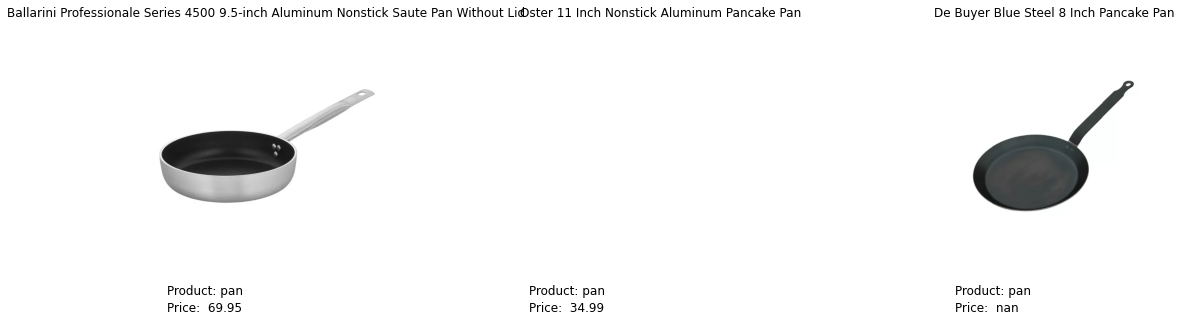

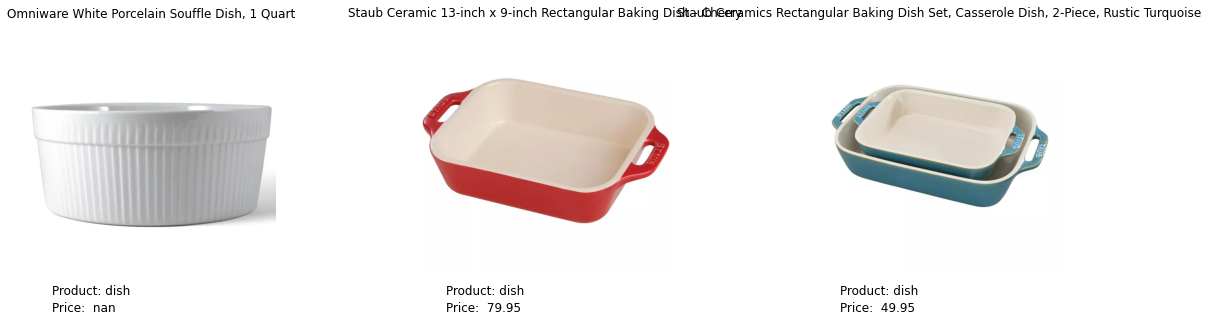

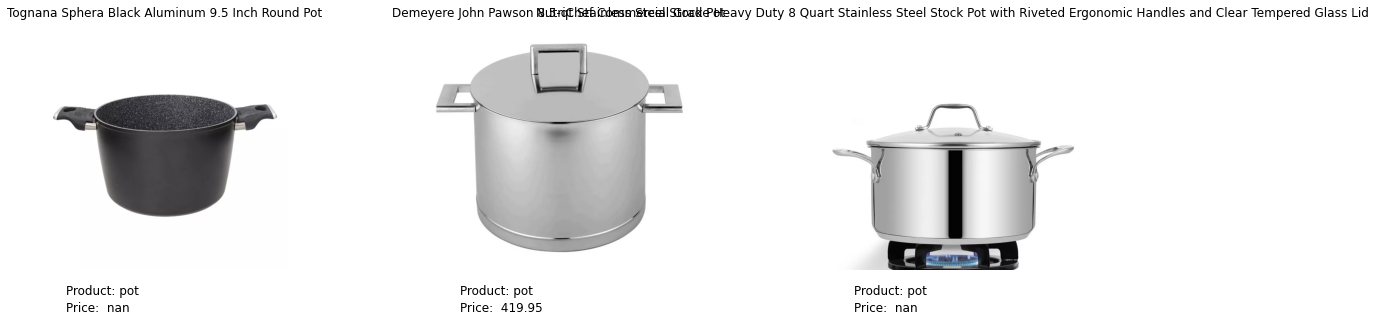

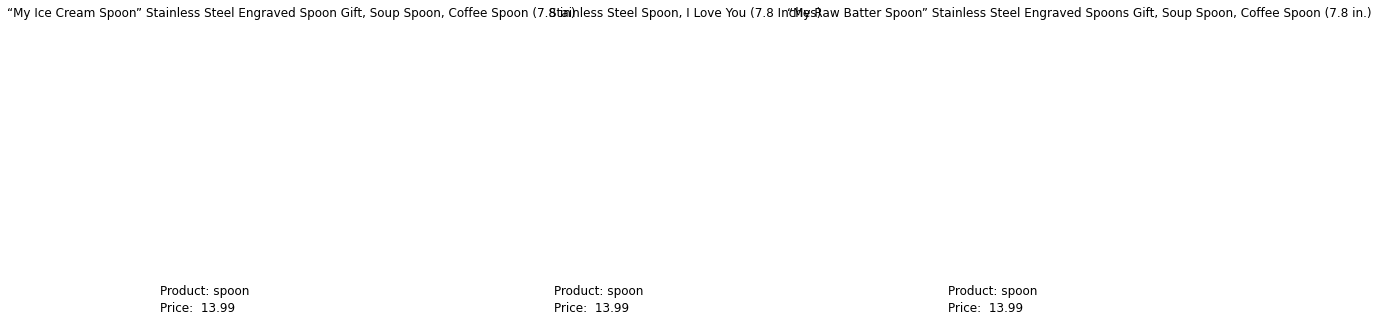

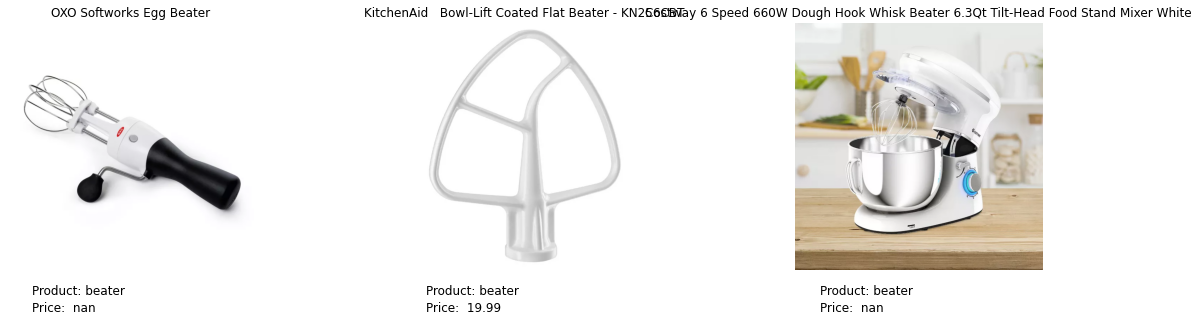

In [116]:
dp.display_products_df_kitchen_gadgets(display_df, 3)

In [ ]:
#not working
# recipe_loaded = recipe_load(6728)